In [115]:
import joblib
import pandas as pd
import numpy as np
import logging

from track_linearization import get_linearized_position

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    path = "/Users/edeno/Downloads/"
    animal_date_epoch = "j1620210710_02_r1"
    position_info = pd.read_pickle(path + f"{animal_date_epoch}_position_info.pkl")
    spike_times = joblib.load(path + f"{animal_date_epoch}_HPC_spike_times.pkl")
    track_graph = joblib.load(path + f"{animal_date_epoch}_track_graph.pkl")
    linear_edge_order = joblib.load(path + f"{animal_date_epoch}_linear_edge_order.pkl")
    linear_edge_spacing = joblib.load(
        path + f"{animal_date_epoch}_linear_edge_spacing.pkl"
    )

    return (
        position_info,
        spike_times,
        track_graph,
        linear_edge_order,
        linear_edge_spacing,
    )


position_info, spike_times, track_graph, edge_order, edge_spacing = load_data()
edge_spacing = 1.5
time = position_info.index
position2D = position_info[["head_position_x", "head_position_y"]].to_numpy()
position = get_linearized_position(
    position2D,
    track_graph,
    edge_order,
    edge_spacing,
).linear_position.values

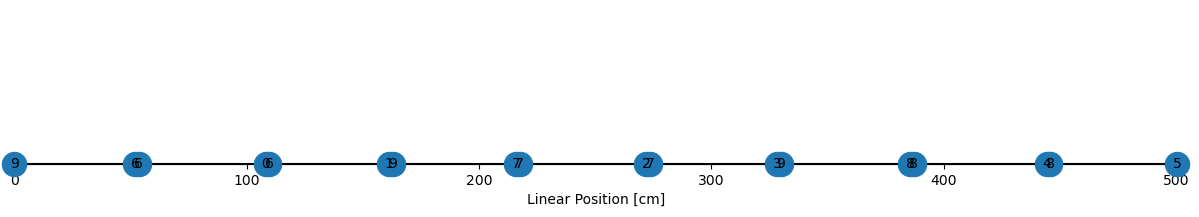

In [15]:
from non_local_detector import Environment

env = Environment(
    track_graph=track_graph,
    edge_order=edge_order,
    edge_spacing=edge_spacing,
)
env.plot_grid()

In [103]:
from non_local_detector.models import (
    NonLocalSortedSpikesDetector,
    ContFragSortedSpikesClassifier,
    SortedSpikesDecoder,
)

cont_model = SortedSpikesDecoder(
    environments=env,
).fit(
    spike_times=spike_times,
    position=position2D,
    position_time=time,
)

cont_frag_model = ContFragSortedSpikesClassifier(
    environments=env,
).fit(
    spike_times=spike_times,
    position=position2D,
    position_time=np.asarray(time),
)

# non_local_model = NonLocalSortedSpikesDetector(
#     environments=env,
# ).fit(
#     spike_times=spike_times,
#     position=position,
#     position_time=np.asarray(time),
# )

21-Mar-25 09:51:14 Fitting initial conditions...
21-Mar-25 09:51:14 Fitting discrete state transition
21-Mar-25 09:51:14 Fitting continuous state transition...
21-Mar-25 09:51:16 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

21-Mar-25 09:51:26 Fitting initial conditions...
21-Mar-25 09:51:26 Fitting discrete state transition
21-Mar-25 09:51:26 Fitting continuous state transition...
21-Mar-25 09:51:28 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

In [104]:
cont_results = cont_model.predict(
    spike_times=spike_times,
    time=time,
    position_time=time,
    position=position2D,
    save_log_likelihood_to_results=True,
    cache_likelihood=True,
)

cont_frag_results = cont_frag_model.predict(
    spike_times=spike_times,
    time=time,
    position_time=time,
    position=position2D,
    save_log_likelihood_to_results=True,
    cache_likelihood=True,
)

# non_local_results = non_local_classifier.predict(
#     spike_times=spike_times,
#     time=time,
#     position_time=time,
#     position=position,
#     cache_likelihood=True,
# )

21-Mar-25 09:51:40 Computing posterior...
21-Mar-25 09:51:40 Computing log likelihood...


Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

21-Mar-25 09:53:24 Computing posterior...
21-Mar-25 09:53:24 Computing log likelihood...


Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

In [105]:
from non_local_detector.model_checking.posterior_consistency import (
    posterior_consistency_hpd_overlap,
)

cont_hpd_overlap = posterior_consistency_hpd_overlap(
    posterior=cont_results.acausal_posterior.dropna("state_bins").to_numpy(),
    likelihood=np.exp(cont_results.log_likelihood.dropna("state_bins").to_numpy()),
)
cont_frag_hpd_overlap = posterior_consistency_hpd_overlap(
    posterior=cont_frag_results.acausal_posterior.dropna("state_bins").to_numpy(),
    likelihood=np.exp(cont_frag_results.log_likelihood.dropna("state_bins").to_numpy()),
)

In [137]:
import matplotlib.pyplot as plt
from scipy.ndimage import label


def plot_spike_times(spike_times, time_slice, ax=None, sort_order=None):
    if ax is None:
        ax = plt.gca()
    time_slice_spike_times = [
        neuron_spike_times[
            (neuron_spike_times >= time_slice.start)
            & (neuron_spike_times < time_slice.stop)
        ]
        for neuron_spike_times in spike_times
    ]

    if sort_order is not None:
        time_slice_spike_times = [time_slice_spike_times[i] for i in sort_order]

    ax.eventplot(
        time_slice_spike_times,
        linelengths=0.5,
        colors="black",
        rasterized=True,
    )


def plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold = 0.2,
):

    time_slice = slice(time[time_slice_ind.start], time[time_slice_ind.stop])

    cont_frag_bad_overlap_labels, n_cont_frag_bad_overlap_labels = label(
        cont_frag_hpd_overlap[time_slice_ind] < overlap_threshold
    )

    cont_bad_overlap_labels, n_cont_bad_overlap_labels = label(
        cont_hpd_overlap[time_slice_ind] < overlap_threshold
    )

    sort_order = np.argsort(
        cont_model.environments[0]
        .place_bin_centers_[
            cont_model.encoding_model_[("", 0)]["place_fields"].argmax(axis=1)
        ]
        .squeeze()
    )

    fig, axes = plt.subplots(4, 1, figsize=(7, 8), sharex=True, constrained_layout=True)
    cont_results.acausal_posterior.isel(time=time_slice_ind).unstack("state_bins").sum(
        "state"
    ).plot(
        x="time",
        y="position",
        ax=axes[0],
        add_colorbar=False,
        robust=True,
        cmap="bone_r",
        rasterized=True,
    )
    axes[0].set_title("Continuous Decoder")
    axes[0].scatter(
        time[time_slice_ind],
        position[time_slice_ind],
        color="magenta",
        s=1,
        rasterized=True,
        clip_on=False,
    )

    for label_ in range(1, n_cont_bad_overlap_labels + 1):
        bad_overlap_ind = np.where(cont_bad_overlap_labels == label_)[0]
        axes[0].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:blue",
            alpha=0.5,
        )
        axes[2].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:blue",
            alpha=0.5,
        )

    cont_frag_results.acausal_posterior.isel(time=time_slice_ind).unstack(
        "state_bins"
    ).sum("state").plot(
        x="time",
        y="position",
        ax=axes[1],
        add_colorbar=False,
        robust=True,
        cmap="bone_r",
        rasterized=True,
    )
    axes[1].scatter(
        time[time_slice_ind],
        position[time_slice_ind],
        color="magenta",
        s=1,
        rasterized=True,
        clip_on=False,
    )
    axes[1].set_title("Continuous Fragmented Decoder")

    for label_ in range(1, n_cont_frag_bad_overlap_labels + 1):
        bad_overlap_ind = np.where(cont_frag_bad_overlap_labels == label_)[0]
        axes[1].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:orange",
            alpha=0.5,
        )
        axes[2].axvspan(
            time[time_slice_ind][bad_overlap_ind[0]],
            time[time_slice_ind][bad_overlap_ind[-1]],
            color="tab:orange",
            alpha=0.5,
        )

    plot_spike_times(spike_times, time_slice, ax=axes[2], sort_order=sort_order)

    axes[3].plot(
        time[time_slice_ind], cont_hpd_overlap[time_slice_ind], label="Continuous"
    )
    axes[3].plot(
        time[time_slice_ind],
        cont_frag_hpd_overlap[time_slice_ind],
        label="Continuous Fragmented",
    )
    axes[3].legend()

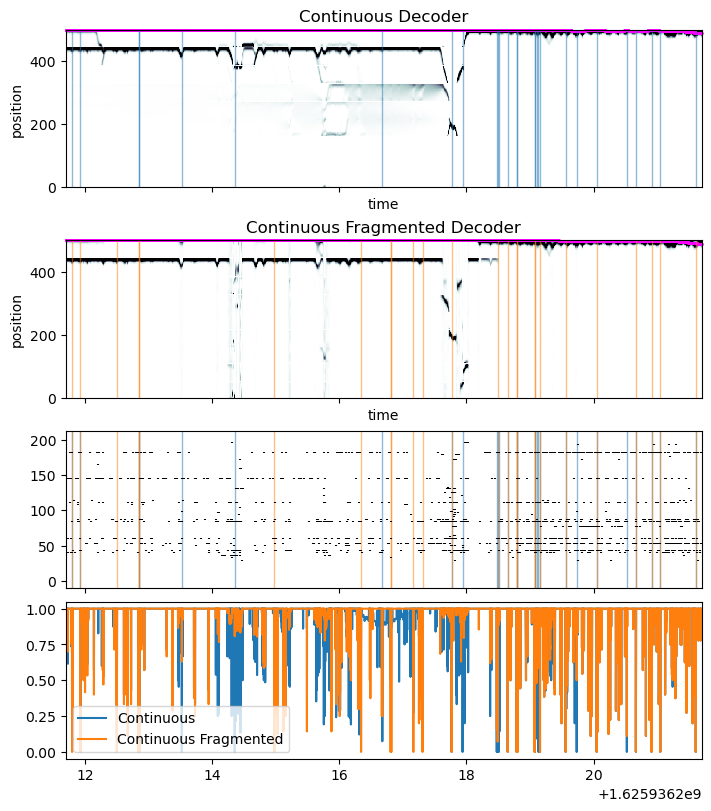

In [144]:
time_slice_ind = slice(227_000, 232_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1,
)

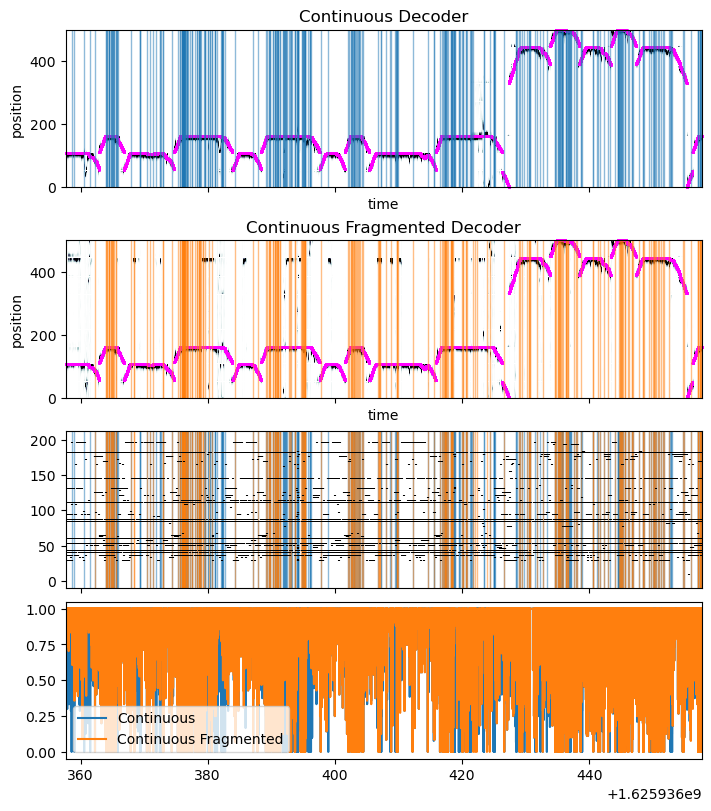

In [145]:
time_slice_ind = slice(300_000, 350_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1,
)

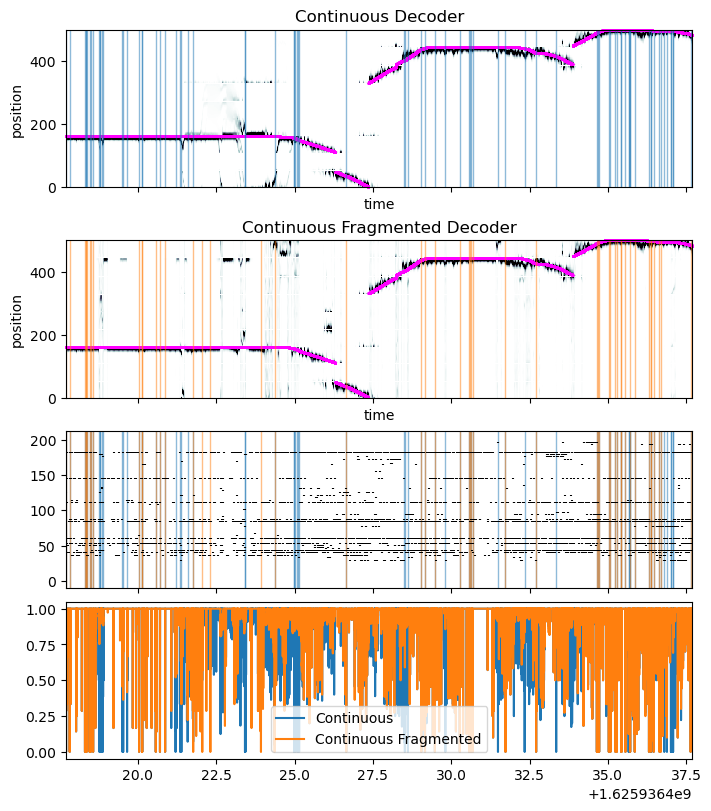

In [146]:
from scipy.ndimage import label

time_slice_ind = slice(330_000, 340_000)
plot_model_checking(
    time_slice_ind,
    time,
    position,
    spike_times,
    cont_model,
    cont_frag_model,
    cont_results,
    cont_frag_results,
    cont_hpd_overlap,
    cont_frag_hpd_overlap,
    overlap_threshold=0.1
)

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

Text(0.5, 0, 'Position')

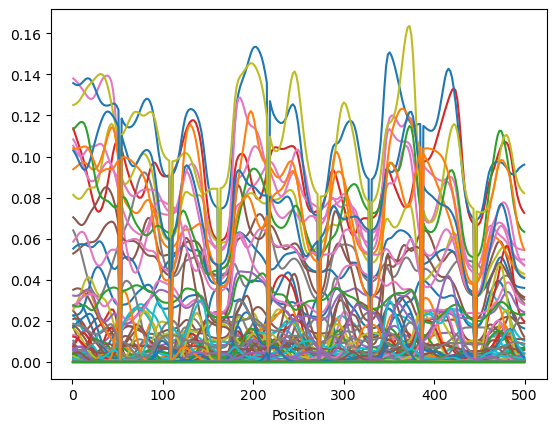

In [108]:
plt.plot(cont_model.environments[0].place_bin_centers_, cont_model.encoding_model_[("", 0)]["place_fields"].T)
plt.xlabel("Position")

In [ ]:
cont_model.environments[0].place_bin_centers_

203

In [109]:
cont_model.encoding_model_[("", 0)]["place_fields"].shape

(203, 256)